In [249]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

$\frac{\partial u}{\partial t} - \frac{\partial^2u}{\partial x^2} = 0$,      $0\leq x \leq \pi,t\geq 0$  
$u(x,0) = \sin(x)$ :$IC$  
$u(0,t) = u(\pi, t) = 0$, $t\geq 0$ :$BC$

# Setting up

In [250]:
t_0, t_n = 0, 5
x_0, x_n = 0, np.pi
gt_fn = lambda x, t: np.sin(x) * np.exp(-t)

In [251]:
def make_hx(h_t):
    return np.sqrt(2*h_t)

def make_L(n_x):
    L = np.eye(n_x) * 2 - np.eye(n_x, k=1) - np.eye(n_x, k=-1)
    return L

In [252]:
search_resolution = 0.05
max_h_t = 0.5
min_h_t = 0.005
h_ts = np.linspace(min_h_t, max_h_t, int((max_h_t - min_h_t) / search_resolution) + 1)
h_ts


array([0.005, 0.06 , 0.115, 0.17 , 0.225, 0.28 , 0.335, 0.39 , 0.445,
       0.5  ])

In [253]:
u_grids= []

def get_u_grid(h_x, h_t, x_grid, t_grid):
    n_x = len(x_grid)
    L = make_L(n_x)
    A = (np.eye(n_x) - (h_t/(h_x**2))*L)
    
    u_grid = [np.sin(x_grid)] # starting from inital condition
    for _ in t_grid:
        last_u = u_grid[-1]
        u_grid.append(A @ last_u)
    # [u_grid.append(A @ u_grid[-1]) for _ in t_grid]
    return np.column_stack(u_grid[1:]) # removing initial condition as it is not part of our solution

def get_solution_from_ht(h_t):
    h_x = make_hx(h_t)
    x_grid = np.linspace(x_0, x_n, int(x_n/h_x)+1)[1:-1]
    t_grid = np.linspace(t_0, t_n, int(t_n/h_t)+1)[1:]
    print(f"h_t: {h_t}, h_x: {h_x}")
    return x_grid, t_grid, get_u_grid(h_x, h_t, x_grid, t_grid), h_x, h_t

for h_t in tqdm(h_ts):
    u_grids.append(get_solution_from_ht(h_t))




100%|██████████| 10/10 [00:00<00:00, 944.05it/s]

h_t: 0.005, h_x: 0.1
h_t: 0.06, h_x: 0.34641016151377546
h_t: 0.115, h_x: 0.47958315233127197
h_t: 0.17, h_x: 0.5830951894845301
h_t: 0.225, h_x: 0.6708203932499369
h_t: 0.28, h_x: 0.7483314773547883
h_t: 0.335, h_x: 0.8185352771872451
h_t: 0.39, h_x: 0.8831760866327847
h_t: 0.445, h_x: 0.9433981132056604
h_t: 0.5, h_x: 1.0


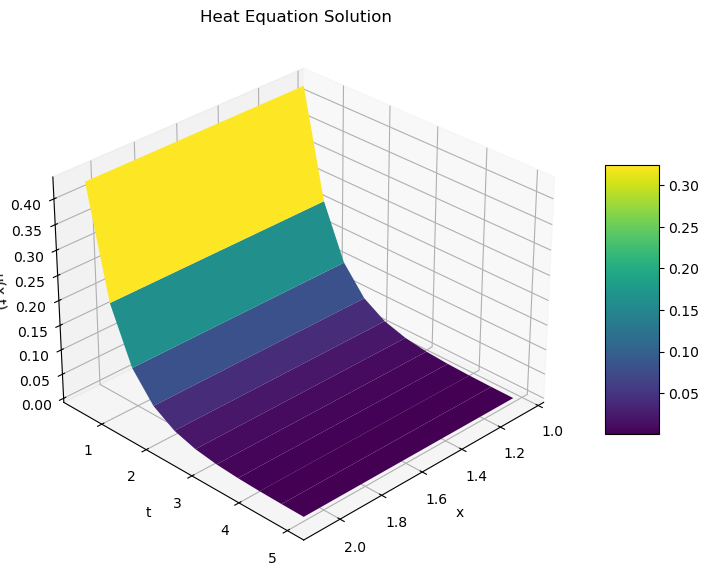

In [254]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

def plot_solution_3d(x_axis, t_axis, u_grid):
    """
    Plot 3D surface of solution (interactive).
    
    Args:
        x_axis: 1D array of x values
        t_axis: 1D array of t values
        u_grid: 2D array of shape (len(x_axis), len(t_axis))
    """
    X, T = np.meshgrid(x_axis, t_axis, indexing='ij')
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    surf = ax.plot_surface(X, T, u_grid, cmap='viridis')
    
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u(x,t)')
    ax.set_title('Heat Equation Solution')
    ax.view_init(elev=30, azim=45)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    plt.show()

# Usage with your data:
x_grid, t_grid, u_grid, h_x, h_t = u_grids[8]  # pick a solution
plot_solution_3d(x_grid, t_grid, u_grid)

# Error calculation setup

In [255]:
def relative_error(x_grid, t_grid, u_grid, fn):
    # print(f"x_grid: {x_grid}")
    gt_samples = np.array([
        [fn(x, t) for t in t_grid]
    for x in x_grid])
    # print(f"u shape: {u_grid.shape}")
    errors = u_grid - gt_samples
    err_norm = np.linalg.norm(errors, axis=1)
    solution_norm = np.linalg.norm(gt_samples, axis=1)
    # print(f"u norm: {solution_norm}, err : {err_norm}")
    # print(f"div: {err_norm / solution_norm}")
    # print(f"gt norm: {np.linalg.norm(gt_samples)}")
    return err_norm / solution_norm

In [256]:
def calc_rel_err_under(u_grids):
    err_grids = []
    for s in u_grids:
        x_grid, t_grid, u_grid, h_x, h_t = s
        rel_err_vec = relative_error(x_grid, t_grid, u_grid, gt_fn)
        infinte_norm = np.linalg.norm(rel_err_vec, ord=np.inf)

        err_grids.append((x_grid, t_grid, u_grid, h_x, h_t, infinte_norm))
        # print(f"h_x: {h_x}, h_t: {h_t} max: {infinte_norm}")

    return err_grids

def find_rel_err_under(err_grids, percent=0.02):
    for s in err_grids:
        if s[-1] <= percent:
            return s


In [257]:
def plot_errs_vs_ht(h_ts, errs):
    plt.figure(figsize=(6,4))
    plt.plot(h_ts, errs, '-o')
    plt.xlabel('h_t')
    plt.ylabel('max relative error (inf norm)')
    plt.title('Error vs time step h_t')
    plt.grid(True)
    # optional: log scale if errors span many orders
    # plt.yscale('log')
    plt.show()

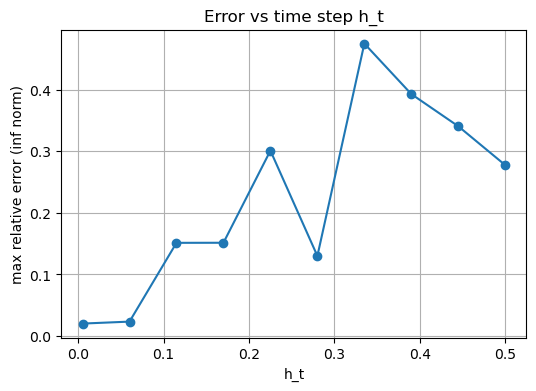

In [258]:
u_grids_err = calc_rel_err_under(u_grids)

def plot_err_across_search_domain(u_grids_err):
    hts = [h_t for x_grid, t_grid, u_grid, h_x, h_t, err in u_grids_err]
    errs = [err for x_grid, t_grid, u_grid, h_x, h_t, err in u_grids_err]
    plot_errs_vs_ht(hts, errs)

plot_err_across_search_domain(u_grids_err)


h_t: 0.445


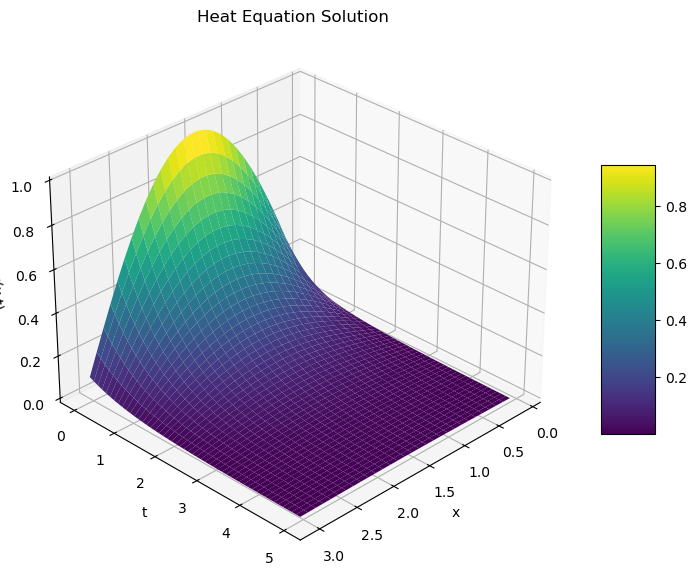

In [259]:
acc_x, acc_t, acc_u, acc_h_x, acc_h_t, err = find_rel_err_under(u_grids_err)
print(f"h_t: {h_t}")
plot_solution_3d(acc_x, acc_t, acc_u)

100%|██████████| 3/3 [00:00<00:00, 79.68it/s]


h_t: 0.005, h_x: 0.1
h_t: 0.0025, h_x: 0.07071067811865475
h_t: 0.00125, h_x: 0.05
hts_0: [0.005, 0.0025, 0.00125]
errs_0: [0.01994465836563338, 0.014245305561666748, 0.01901027222654055]


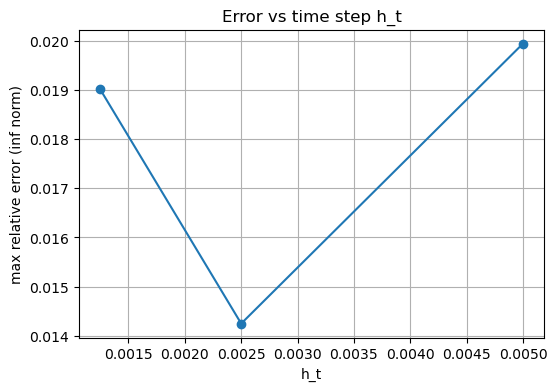

In [260]:
hts_0 = [acc_h_t, acc_h_t / 2, acc_h_t / 4]
u_grids_0 = [get_solution_from_ht(h_t) for h_t in tqdm(hts_0)]

errs_0 = [np.linalg.norm(relative_error(x_grid, t_grid, u_grid, gt_fn), ord=np.inf) for x_grid, t_grid, u_grid, h_x, h_t in u_grids_0]

print(f"hts_0: {hts_0}")
print(f"errs_0: {errs_0}")

plot_errs_vs_ht(hts_0, errs_0)